### How Does Direct Deposit Plays an effect
---

* Purpose:
    * The final goal for investigating the impact of direct deposit is to see if we can build customer experience strategies to help uses get into a better RG, like 4,5 -> 1-3.
    * Big push right for now DD from business.
    * One of the concerns is if we are targeting and incentivizing DD
    * **Will your model differentiate between a dd cohort vs. non-dd cohort**

* Quesitons trying to answer:
    * **Will your model differentiate between a dd cohort vs. non-dd cohort**?
    * Will DD cohorts migrate from 4/5 -> 3 or better faster than not signing up for dd?
    * Which variables can be attributed to dd and how they rank vs. others (top 5, top 10, bottom 10)… for dd and non dd customers?
    * Get two groups, one have DD in the first month, the other without. Is their score different over time?


* If there is no material lift, then the next step would be to implement strategies that align with the business push to target and incentivize dd. If we have it, then we don't need to worry about it down the road.

In [1]:
!pip install lightgbm shap seaborn

     |████████████████████████████████| 1.8 MB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 326 kB 31.5 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=447486 sha256=ac4432884483f34e3e559c57e79c333e8c3fde7d4ff22d1a3b5234df2f0e3b72
  Stored in directory: /home/ec2-user/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built shap


In [2]:
import sys, os
sys.path.insert(1, '../..')
import pandas as pd
import numpy as np
import pickle as pkl
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap, math
from tqdm import tqdm


# feature preprocessing, if needed
from train import preprocess

plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

### Load Data and Model
---

In [3]:
modeling_df = pd.read_feather("../../artifacts/modeling_df_final_with_oof_preds_replication.feather")
modeling_df = preprocess(modeling_df)
modeling_df.shape

(1086183, 48)

In [4]:
# get scores
model = pkl.load(open('../../models/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb'))

In [5]:
def scale_scores(predictions):
    """
    Convert probability to score.
    """
    try:
        assert ((predictions >= 0) & (predictions <= 1)).all(), 'probability must be in range [0,1]'
    except AssertionError:
        raise

    # Formula parameters
    ALPHA = 631.9455383610933
    BETA = 30.812519272450654

    # Minimum and maximum values for validation
    MINIMUM = 300
    MAXIMUM = 850

    score = np.minimum(np.maximum(np.log(predictions / (1 - predictions)) * BETA + ALPHA, MINIMUM), MAXIMUM)
   
    return score

In [6]:
modeling_df['score'] = scale_scores(modeling_df['pred'])

In [7]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

modeling_df['risk_group'] = get_risk_groups(modeling_df.score)

### Features
--- 
- dollar_val_dd (nr 24)
- nr_direct_deposits (nr 39)

Final Question: Will your model differentiate between a dd cohort vs. non-dd cohort?

In [77]:
%%time 

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(modeling_df[model.feature_name_])[1]


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


CPU times: user 1h 22min 54s, sys: 1.2 s, total: 1h 22min 55s
Wall time: 5min 24s


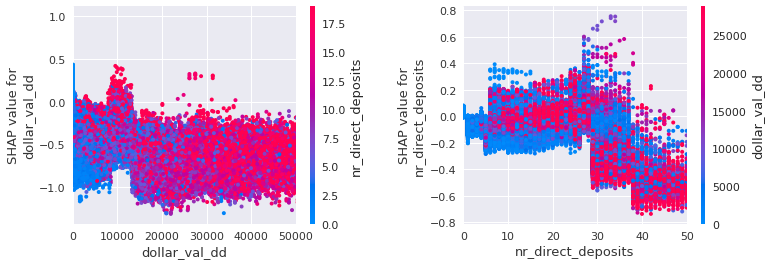

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
shap.dependence_plot("dollar_val_dd", shap_values, 
                     modeling_df[model.feature_name_], ax=ax[0], show=False,
                     interaction_index="nr_direct_deposits")
shap.dependence_plot("nr_direct_deposits", shap_values, 
                     modeling_df[model.feature_name_], ax=ax[1], show=False,
                     interaction_index="dollar_val_dd")
ax[0].set_xlim(0, 50000)
ax[1].set_xlim(0, 50)
plt.subplots_adjust(wspace=0.4)

The model does exhibits a downward trend for dd based features, as the more direct deposits we see, the safer the account is.

Four things to do:
1. [ ] What fraction had dd set up?
2. [ ] Separate data into 2 groups, RG1-3, and RG 4-5. Let's look at the score difference.
3. [ ] ? Sample/build data points from the dataset, then manually modify these two features and oberve the difference.
4. [ ] Look at the group that set up DD during the first month. See the difference.

In [8]:
# take the lastest accounts
modeling_df.business_account_number.nunique()

109761

In [9]:
def get_first_row_idx(df, date_col="sample_date"):
    return df.sort_values(date_col).iloc[0].idx

def get_last_row_idx(df, date_col="sample_date"):
    return df.sort_values(date_col).iloc[-1].idx

In [11]:
%%time 
modeling_df["idx"] = modeling_df.index
df_ = modeling_df.groupby('business_account_number')[["sample_date", "idx"]].apply(get_first_row_idx)
df_first = modeling_df.iloc[df_.values]

modeling_df["idx"] = modeling_df.index
df_ = modeling_df.groupby('business_account_number')[["sample_date", "idx"]].apply(get_last_row_idx)
df_last = modeling_df.iloc[df_.values]

CPU times: user 2min 24s, sys: 361 ms, total: 2min 25s
Wall time: 2min 25s


In [82]:
%%time 

shap.initjs()
explainer_first = shap.TreeExplainer(model)
shap_values_first = explainer_first.shap_values(df_first[model.feature_name_])[1]

shap.initjs()
explainer_last = shap.TreeExplainer(model)
shap_values_last = explainer_last.shap_values(df_last[model.feature_name_])[1]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


CPU times: user 16min 46s, sys: 172 ms, total: 16min 47s
Wall time: 1min 5s


#### First Day Since Account Opens

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


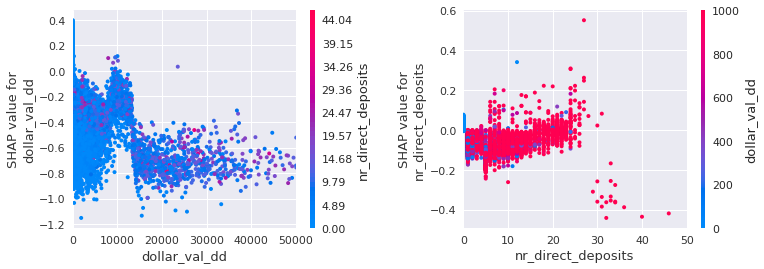

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
shap.dependence_plot("dollar_val_dd", shap_values_first, 
                     df_first[model.feature_name_], ax=ax[0], show=False,
                     interaction_index="nr_direct_deposits")
shap.dependence_plot("nr_direct_deposits", shap_values_first, 
                     df_first[model.feature_name_], ax=ax[1], show=False,
                     interaction_index="dollar_val_dd")
ax[0].set_xlim(0, 50000)
ax[1].set_xlim(0, 50)
plt.subplots_adjust(wspace=0.4)

#### Last Sample Date

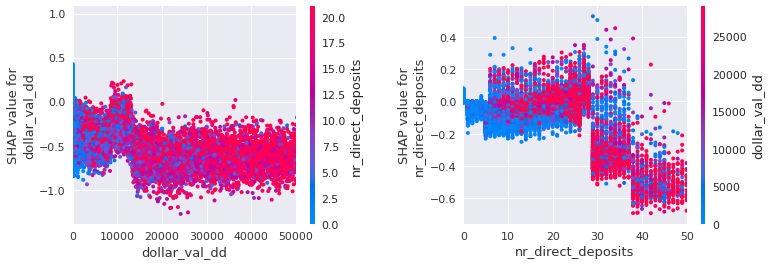

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
shap.dependence_plot("dollar_val_dd", shap_values_last, 
                     df_last[model.feature_name_], ax=ax[0], show=False,
                     interaction_index="nr_direct_deposits")
shap.dependence_plot("nr_direct_deposits", shap_values_last, 
                     df_last[model.feature_name_], ax=ax[1], show=False,
                     interaction_index="dollar_val_dd")
ax[0].set_xlim(0, 50000)
ax[1].set_xlim(0, 50)
plt.subplots_adjust(wspace=0.4)

#### What fraction had dd set up?

In [12]:
df_first["has_dd"] = df_first["nr_direct_deposits"] > 0
df_first["has_dd"].value_counts(normalize=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


False    0.926668
True     0.073332
Name: has_dd, dtype: float64

In [13]:
df_last["has_dd"] = df_last["nr_direct_deposits"] > 0
df_last["has_dd"].value_counts(normalize=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


False    0.818032
True     0.181968
Name: has_dd, dtype: float64

#### Separate data into 2 groups, RG1-3, and RG 4-5. Let's look at the score difference.

In [14]:
df_low_rg = modeling_df[modeling_df.risk_group.isin(["RG1", "RG2", "RG3"])]
df_high_rg = modeling_df[modeling_df.risk_group.isin(["RG4", "RG5"])]

modeling_df['low_rg'] = modeling_df.risk_group.isin(["RG1", "RG2", "RG3"])
modeling_df['high_rg'] = modeling_df.risk_group.isin(["RG4", "RG5"])

In [15]:
result = modeling_df.groupby("low_rg")[["nr_direct_deposits", "dollar_val_dd"]].agg(["mean", "std"])
result.index=["RG1-3", "RG4-5"]
result

nr_direct_deposits           dollar_val_dd              
                    mean       std          mean           std
RG1-3           1.030418  3.862069    676.890495   4120.138418
RG4-5           4.084638  8.260667   6521.345304  19310.557339

low_rg
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: nr_direct_deposits, dtype: object

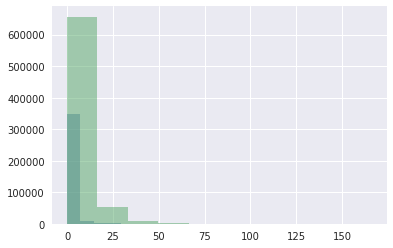

In [16]:
modeling_df.groupby("low_rg")["nr_direct_deposits"].hist(bins=10, alpha=0.5)

(0.0, 50.0)

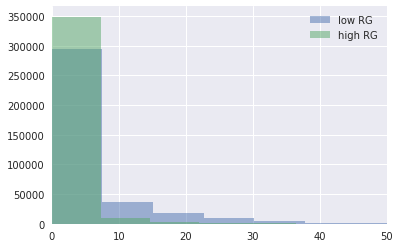

In [17]:
df_low_rg.sample(n=len(df_high_rg), 
                 random_state=42).nr_direct_deposits.hist(bins=22, alpha=0.5, label='low RG')
df_high_rg.nr_direct_deposits.hist(bins=10, alpha=0.5, label='high RG')
plt.legend()
plt.xlim(0, 50)

In [18]:
modeling_df.groupby("risk_group")[["nr_direct_deposits", "dollar_val_dd"]].agg(["mean", "std"])

nr_direct_deposits            dollar_val_dd              
                         mean        std          mean           std
risk_group                                                          
RG1                  7.283643  10.814279  12247.426582  25860.038669
RG2                  4.493646   8.469488   7603.251806  21147.976026
RG3                  2.636195   6.505359   3669.907686  13827.275795
RG4                  1.540896   4.898999   1155.399839   5929.988516
RG5                  0.653267   2.805172    323.358289   1800.813654

3. [ ] ? Sample/build data points from the dataset, then manually modify these two features and oberve the difference.

In [19]:
sample_df = modeling_df[modeling_df["nr_direct_deposits"] == 0]
sample_df_combined = sample_df.copy()
sample_df_combined["rg"] = sample_df_combined["risk_group"]
sample_df_combined["score"] = sample_df_combined["score"]
sample_df[["nr_direct_deposits", "dollar_val_dd"]].agg(["mean", "std"])

,nr_direct_deposits,dollar_val_dd
mean,0.0,0.0
std,0.0,0.0



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

<AxesSubplot:>

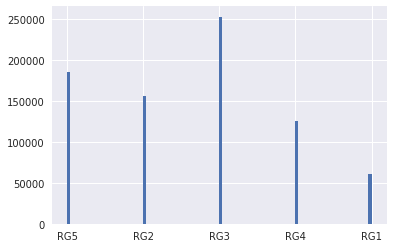

In [20]:
sample_df = modeling_df[modeling_df["nr_direct_deposits"] == 0]
# build data with nr_direct_deposits = 5
sample_df["nr_direct_deposits"] = 5
sample_df["pred"] = model.predict_proba(sample_df[model.feature_name_])[:, 1]
sample_df['score_ndd'] = scale_scores(sample_df['pred'])
sample_df['rg_ndd'] = get_risk_groups(sample_df.score_ndd)
sample_df_combined["score_ndd"] = sample_df["score_ndd"]
sample_df_combined["rg_ndd"] = sample_df["rg_ndd"]
sample_df.risk_group.hist(bins=100)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

<AxesSubplot:>

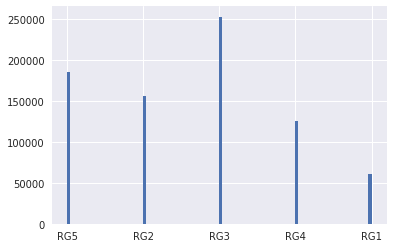

In [21]:
sample_df = modeling_df[modeling_df["nr_direct_deposits"] == 0]
# build data with dollar_val_dd = 10000
sample_df["dollar_val_dd"] = 10000
sample_df["pred"] = model.predict_proba(sample_df[model.feature_name_])[:, 1]
sample_df['score_dvd'] = scale_scores(sample_df['pred'])
sample_df['rg_dvd'] = get_risk_groups(sample_df.score_dvd)
sample_df_combined["score_dvd"] = sample_df["score_dvd"]
sample_df_combined["rg_dvd"] = sample_df["rg_dvd"]
sample_df.risk_group.hist(bins=100)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

<AxesSubplot:>

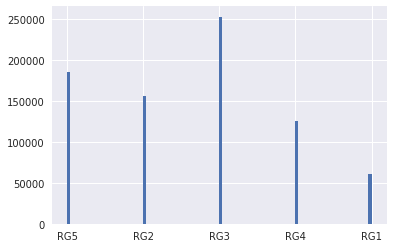

In [22]:
sample_df = modeling_df[modeling_df["nr_direct_deposits"] == 0]
sample_df["nr_direct_deposits"] = 5
sample_df["dollar_val_dd"] = 10000
sample_df["pred"] = model.predict_proba(sample_df[model.feature_name_])[:, 1]
sample_df['score_ndd_dvd'] = scale_scores(sample_df['pred'])
sample_df['rg_ndd_dvd'] = get_risk_groups(sample_df.score_ndd_dvd)
sample_df_combined["score_ndd_dvd"] = sample_df["score_ndd_dvd"]
sample_df_combined["rg_ndd_dvd"] = sample_df["rg_ndd_dvd"]
sample_df.risk_group.hist(bins=100)

In [96]:
sample_df_combined[['rg_dvd',
                    'rg_ndd',
                    'rg_ndd_dvd',
                    'risk_group']].head()

,rg_dvd,rg_ndd,rg_ndd_dvd,risk_group
9,RG5,RG5,RG5,RG5
12,RG2,RG1,RG2,RG2
13,RG3,RG3,RG2,RG3
16,RG5,RG5,RG5,RG5
18,RG1,RG1,RG1,RG2


In [97]:
sample_df_combined[['rg',
 'rg_dvd',
 'rg_ndd',
 'rg_ndd_dvd',
 'score',
 'score_dvd',
 'score_ndd',
 'score_ndd_dvd']].head()

,rg,rg_dvd,rg_ndd,rg_ndd_dvd,score,score_dvd,score_ndd,score_ndd_dvd
9,RG5,RG5,RG5,RG5,678.553861,657.770452,678.486860,654.305783
12,RG2,RG2,RG1,RG2,489.958660,477.404997,466.132238,475.157893
13,RG3,RG3,RG3,RG2,544.405116,518.099161,539.554328,509.121864
16,RG5,RG5,RG5,RG5,663.653616,633.432063,648.422357,626.591352
18,RG2,RG1,RG1,RG1,498.001385,465.805336,467.575211,460.261225


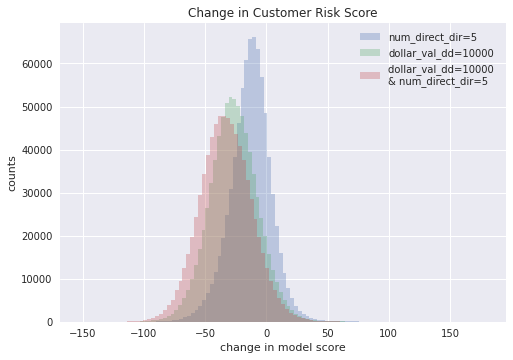

In [160]:
(sample_df_combined["score_ndd"] - sample_df_combined["score"]).hist(bins=100, alpha=0.3, label="num_direct_dir=5")
(sample_df_combined["score_dvd"] - sample_df_combined["score"]).hist(bins=100, alpha=0.3, label="dollar_val_dd=10000")
(sample_df_combined["score_ndd_dvd"] - sample_df_combined["score"]).hist(bins=100, alpha=0.3, label="dollar_val_dd=10000 \n& num_direct_dir=5")
plt.legend()
plt.xlabel("change in model score")
plt.ylabel("counts")
plt.title("Change in Customer Risk Score")
plt.show()

In [99]:
sample_df_combined['rg_int'] = sample_df_combined['rg'].apply(lambda x: int(x[-1])).astype(int)
sample_df_combined['rg_dvd_int'] = sample_df_combined['rg_dvd'].apply(lambda x: int(x[-1])).astype(int)
sample_df_combined['rg_ndd_int'] = sample_df_combined['rg_ndd'].apply(lambda x: int(x[-1])).astype(int)
sample_df_combined['rg_ndd_dvd_int'] = sample_df_combined['rg_ndd_dvd'].apply(lambda x: int(x[-1])).astype(int)

No handles with labels found to put in legend.


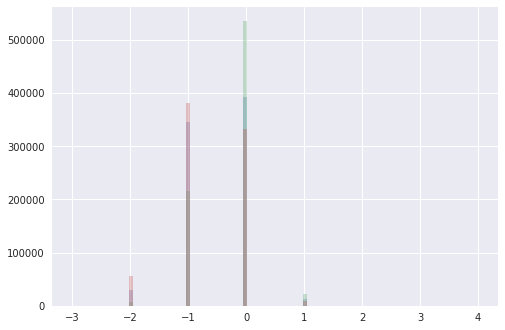

In [100]:
(sample_df_combined["rg_dvd_int"] - sample_df_combined["rg_int"]).hist(bins=100, alpha=0.3)
(sample_df_combined["rg_ndd_int"] - sample_df_combined["rg_int"]).hist(bins=100, alpha=0.3)
(sample_df_combined["rg_ndd_dvd_int"] - sample_df_combined["rg_int"]).hist(bins=100, alpha=0.3)
plt.legend()

4. [ ] Look at the group that set up DD during the first month. See the difference.

In [101]:
modeling_df.head()

,business_account_number,borrower_id,sample_date,target,transaction_code,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,...,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,pred,score,risk_group,idx,low_rg,high_rg
0,410000087395,5750052,2019-03-27 09:59:22,False,ACHDW,50.00,NaN,NaN,0.0272,NaN,...,309,5,-1.0,-1.0,0.085010,558.730520,RG3,0,True,False
1,410001352464,7313147,2019-09-20 05:50:31,False,ACHDDIN,2000.00,734.0,27.0,0.6170,0.312,...,176,4,-1.0,-1.0,0.017006,506.938453,RG2,1,True,False
2,410000287298,2176154,2019-01-25 05:49:11,False,ACHINDD,100.00,NaN,NaN,0.0108,NaN,...,71,6,-1.0,-1.0,0.055994,544.903416,RG3,2,True,False
3,410000361702,851298,2019-11-25 10:32:35,False,DWCRDBILLPAY,2980.64,780.0,49.0,0.0077,NaN,...,331,0,-1.0,-1.0,0.025013,519.078743,RG3,3,True,False
4,410000751441,7052381,2019-11-15 06:20:19,False,ACHINDD,300.00,737.0,75.0,0.4790,0.282,...,273,6,-1.0,-1.0,0.002954,452.564025,RG1,4,True,False


<AxesSubplot:>

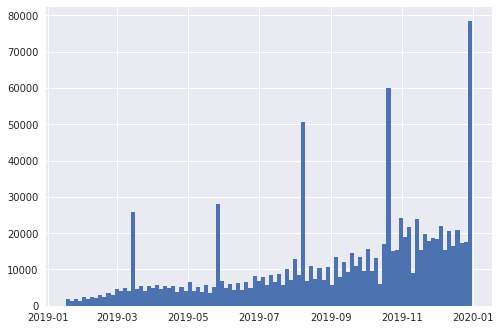

In [102]:
modeling_df.sample_date.hist(bins=100)

* Sample Ids for two groups: have/havenot dd in first month.
* Get group score after 6 months
* Plot score distribution

In [103]:
df_tmp = modeling_df[modeling_df.age_money_account <= 30]
df_tmp["idx"] = df_tmp.index
df_tmp = df_tmp.groupby('business_account_number')[["sample_date", "idx"]].apply(get_last_row_idx)
df_first_mm = modeling_df.iloc[df_tmp.values]

df_first_mm["has_dd"] = df_first_mm.nr_direct_deposits > 0
display(df_first_mm.has_dd.value_counts())

# ids that have dd in the first months
df_first_mm[df_first_mm.has_dd].business_account_number.head()
bid_dd_first_m = df_first_mm[df_first_mm.has_dd].business_account_number


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


False    80531
True      5258
Name: has_dd, dtype: int64

In [104]:
df_6_mm = modeling_df[modeling_df.age_money_account.between(170,200)]
display(df_6_mm.business_account_number.nunique())
ids_6m = df_6_mm.business_account_number.unique()

26441

In [105]:
ids_dd = df_first_mm[(df_first_mm.business_account_number.isin(ids_6m)) & (df_first_mm.has_dd)].business_account_number
ids_nodd = df_first_mm[(df_first_mm.business_account_number.isin(ids_6m)) & (~df_first_mm.has_dd)].business_account_number
ids_nodd = ids_nodd.sample(len(ids_dd), replace=False)
display(len(ids_dd), len(ids_nodd))

2211

2211

In [106]:
df_6mm_dd = df_6_mm[df_6_mm.business_account_number.isin(ids_dd)]
df_6mm_nodd = df_6_mm[~df_6_mm.business_account_number.isin(ids_dd)]

In [164]:
data = {"mean_score_dd": [],
        "mean_score_nodd": [],
        "mean_nr_direct_deposits_dd": [],
        "mean_dollar_val_dd_nodd": [],
        "mean_nr_direct_deposits_nodd": [],
        "mean_dollar_val_dd_nodd": []}

for m in range(7):
    
    if m > 0:
        df_tmp = modeling_df[(modeling_df.age_money_account < (m*30))]
        df_tmp = df_tmp[df_tmp.business_account_number.isin(ids_6m)]
        df_ = df_tmp.groupby('business_account_number')[["sample_date", "idx"]].apply(get_last_row_idx)
    else:
        df_tmp = modeling_df[modeling_df.business_account_number.isin(ids_6m)]
        df_ = df_tmp.groupby('business_account_number')[["sample_date", "idx"]].apply(get_first_row_idx)
        
    df_tmp = df_tmp.loc[df_.values]  # get the last available transactions
    
    data["mean_score_dd"].append(df_tmp[df_tmp.business_account_number.isin(ids_dd)].score.mean())
    data["mean_score_nodd"].append(df_tmp[df_tmp.business_account_number.isin(ids_nodd)].score.mean())
    data["mean_nr_direct_deposits_dd"].append(df_tmp[df_tmp.business_account_number.isin(ids_dd)].nr_direct_deposits.mean())
    data["mean_dollar_val_dd_dd"].append(df_tmp[df_tmp.business_account_number.isin(ids_dd)].dollar_val_dd.mean())
    data["mean_nr_direct_deposits_nodd"].append(df_tmp[df_tmp.business_account_number.isin(ids_nodd)].nr_direct_deposits.mean())
    data["mean_dollar_val_dd_nodd"].append(df_tmp[df_tmp.business_account_number.isin(ids_nodd)].dollar_val_dd.mean())

KeyError: 'mean_nr_direct_deposits_dd'

In [ ]:
months = [0, 1, 2, 3, 4, 5, 6]
plt.plot(months, data["mean_score_dd"], label="with direct deposits")
plt.plot(months, data["mean_score_nodd"], label="no direct deposits")
plt.legend()
plt.xlabel("Months since account opening")
plt.ylabel("Model Score")
plt.title("Customer Risk Score Progression: first 6 months")
plt.show()

In [ ]:
months = [0, 1, 2, 3, 4, 5, 6]
plt.plot(months, data["mean_nr_direct_deposits_dd"], label="with direct deposits")
plt.plot(months, data["mean_nr_direct_deposits_nodd"], label="no direct deposits")
plt.legend()
plt.xlabel("Months since account opening")
plt.ylabel("mean nr_direct_deposits")
plt.title("nr_direct_deposits Progression: first 6 months")
plt.show()

In [163]:
months = [0, 1, 2, 3, 4, 5, 6]
plt.plot(months, data["mean_dollar_val_dd_dd"], label="with direct deposits")
plt.plot(months, data["mean_dollar_val_dd_nodd"], label="no direct deposits")
plt.legend()
plt.xlabel("Months since account opening")
plt.ylabel("mean dollar_val_dd")
plt.title("dollar_val_dd Progression: first 6 months")
plt.show()

{'mean_score_dd': [568.6309224055581,
  543.7862998143195,
  534.7594114367528,
  520.1338449518344,
  511.1528133892693,
  509.1492475987029,
  504.03731282559613],
 'mean_score_nodd': [590.9049076639219,
  575.8850417539275,
  556.9098875921661,
  540.3404487018278,
  531.0566449488898,
  527.5007948990956,
  522.3638614913892],
 'mean_nr_direct_deposits': [0.7064676616915423,
  1.4491129785247432,
  3.331524197195839,
  5.61917684305744,
  7.956580732700136,
  10.16146540027137,
  12.410673903211217],
 'mean_dollar_val_dd': [0.0,
  0.0,
  355.58474445952055,
  892.7186476707371,
  1532.1132473993666,
  2215.850642243329,
  2952.9178516508364],
 'std_nr_direct_deposits': [0.7064676616915423,
  1.4491129785247432,
  3.331524197195839,
  5.61917684305744,
  7.956580732700136,
  10.16146540027137,
  12.410673903211217],
 'std_dollar_val_dd': [0.0,
  0.0,
  355.58474445952055,
  892.7186476707371,
  1532.1132473993666,
  2215.850642243329,
  2952.9178516508364]}

#### Analysis inquired by Dan
---

For accounts in RG5 and tenure <= 6 months and no direct deposit and balance > 0, if you force them to 2 DDs and $1000 DD amount, what would that risk group distribution look like? Trying to see if that would bring many to RG1-4 or if that's not enough.


In [23]:
modeling_df.head()

,business_account_number,borrower_id,sample_date,target,transaction_code,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,...,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,pred,score,risk_group,idx,low_rg,high_rg
0,410000087395,5750052,2019-03-27 09:59:22,False,ACHDW,50.00,NaN,NaN,0.0272,NaN,...,309,5,-1.0,-1.0,0.085010,558.730520,RG3,0,True,False
1,410001352464,7313147,2019-09-20 05:50:31,False,ACHDDIN,2000.00,734.0,27.0,0.6170,0.312,...,176,4,-1.0,-1.0,0.017006,506.938453,RG2,1,True,False
2,410000287298,2176154,2019-01-25 05:49:11,False,ACHINDD,100.00,NaN,NaN,0.0108,NaN,...,71,6,-1.0,-1.0,0.055994,544.903416,RG3,2,True,False
3,410000361702,851298,2019-11-25 10:32:35,False,DWCRDBILLPAY,2980.64,780.0,49.0,0.0077,NaN,...,331,0,-1.0,-1.0,0.025013,519.078743,RG3,3,True,False
4,410000751441,7052381,2019-11-15 06:20:19,False,ACHINDD,300.00,737.0,75.0,0.4790,0.282,...,273,6,-1.0,-1.0,0.002954,452.564025,RG1,4,True,False


In [62]:
conditions = ((modeling_df["risk_group"] == "RG5")
              & (modeling_df["nr_direct_deposits"] == 0) 
              & (modeling_df["age_money_account"] < 180) 
              & (modeling_df["nr_direct_deposits"] == 0) 
              & (modeling_df["transaction_as_pct_of_balance"] > 0)) # use this to approximate positive account bal
sample_df = modeling_df[conditions]

sample_df["nr_direct_deposits"] = 2
sample_df["dollar_val_dd"] = 1000

sample_df["pred_shifted"] = model.predict_proba(sample_df[model.feature_name_])[:, 1]
sample_df['score_shifted'] = scale_scores(sample_df['pred_shifted'])
sample_df['rg_shifted'] = get_risk_groups(sample_df.score_shifted)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

<AxesSubplot:>

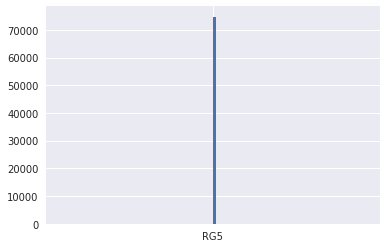

In [64]:
sample_df.risk_group.hist(bins=100)

In [65]:
original_rg = sample_df.risk_group.value_counts().sort_index(ascending=False)
shifted_rg = sample_df.rg_shifted.value_counts().sort_index(ascending=False)

original_rg.rename("original", inplace=True)
shifted_rg.rename("shifted", inplace=True)

combined_rg = original_rg.to_frame().join(shifted_rg.to_frame())
combined_rg

,original,shifted
RG5,74716,39312
RG4,0,25658
RG3,0,9706
RG2,0,40
RG1,0,0


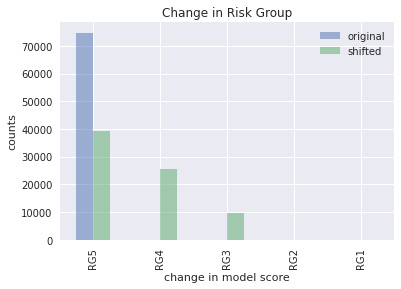

In [66]:
combined_rg.plot.bar(alpha=0.5)
plt.xlabel("change in model score")
plt.ylabel("counts")
plt.title("Change in Risk Group")
plt.show()

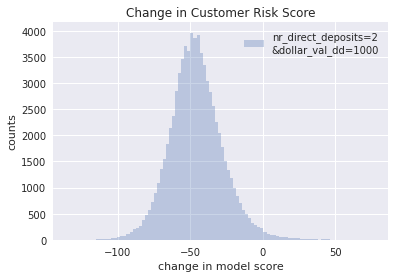

In [68]:
(sample_df["score_shifted"] - sample_df["score"]).hist(bins=100, alpha=0.3, 
                                                                label="nr_direct_deposits=2\n&dollar_val_dd=1000")
plt.legend()
plt.xlabel("change in model score")
plt.ylabel("counts")
plt.title("Change in Customer Risk Score")
plt.show()

Try another number set


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,original,shifted
RG5,74716,37819
RG4,0,24338
RG3,0,12488
RG2,0,71
RG1,0,0


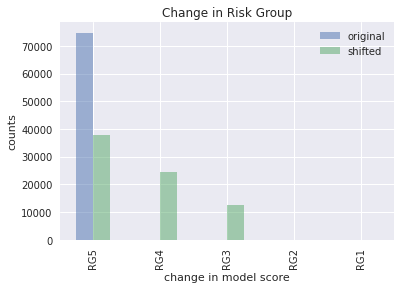

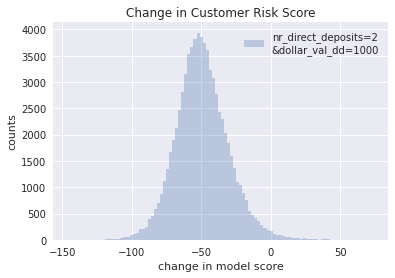

In [71]:
conditions = ((modeling_df["risk_group"] == "RG5")
              & (modeling_df["nr_direct_deposits"] == 0) 
              & (modeling_df["age_money_account"] < 180) 
              & (modeling_df["nr_direct_deposits"] == 0) 
              & (modeling_df["transaction_as_pct_of_balance"] > 0)) # use this to approximate positive account bal
sample_df = modeling_df[conditions]

sample_df["nr_direct_deposits"] = 5
sample_df["dollar_val_dd"] = 2000

sample_df["pred_shifted"] = model.predict_proba(sample_df[model.feature_name_])[:, 1]
sample_df['score_shifted'] = scale_scores(sample_df['pred_shifted'])
sample_df['rg_shifted'] = get_risk_groups(sample_df.score_shifted)

original_rg = sample_df.risk_group.value_counts().sort_index(ascending=False)
shifted_rg = sample_df.rg_shifted.value_counts().sort_index(ascending=False)

original_rg.rename("original", inplace=True)
shifted_rg.rename("shifted", inplace=True)

combined_rg = original_rg.to_frame().join(shifted_rg.to_frame())
display(combined_rg)

combined_rg.plot.bar(alpha=0.5)
plt.xlabel("change in model score")
plt.ylabel("counts")
plt.title("Change in Risk Group")
plt.show()

(sample_df["score_shifted"] - sample_df["score"]).hist(bins=100, alpha=0.3, 
                                                                label="nr_direct_deposits=2\n&dollar_val_dd=1000")
plt.legend()
plt.xlabel("change in model score")
plt.ylabel("counts")
plt.title("Change in Customer Risk Score")
plt.show()